## Imports

In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

## Data loading

In [10]:
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=URL, extract=True)

In [11]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats


In [12]:
zip_dir_base

'/root/.keras/datasets'

In [13]:
base_dir = Path(Path(zip_dir_base)/'cats_and_dogs_filtered')

train_dir = base_dir/'train'
validation_dir = base_dir/'validation'

train_dogs_dir = train_dir/'dogs'
train_cats_dir = train_dir/'cats'
validation_dogs_dir = validation_dir/'dogs'
validation_cats_dir = validation_dir/'cats'

## Setting model parameters

In [14]:
BATCH_SIZE = 100
IMG_SHAPE = 150
EPOCHS = 35

In [15]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [16]:
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.


In [17]:
validation_data_gen = validation_image_generator.flow_from_directory(
    directory=validation_dir,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 1000 images belonging to 2 classes.


## Visualizing training examples

In [18]:
sample_training_images, _ = next(train_data_gen) 

In [19]:
len(sample_training_images)

100

100, because of the batch size being 100

In [20]:
def plot_images(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20, 20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
      ax.imshow(img)
  plt.tight_layout()
  plt.show()

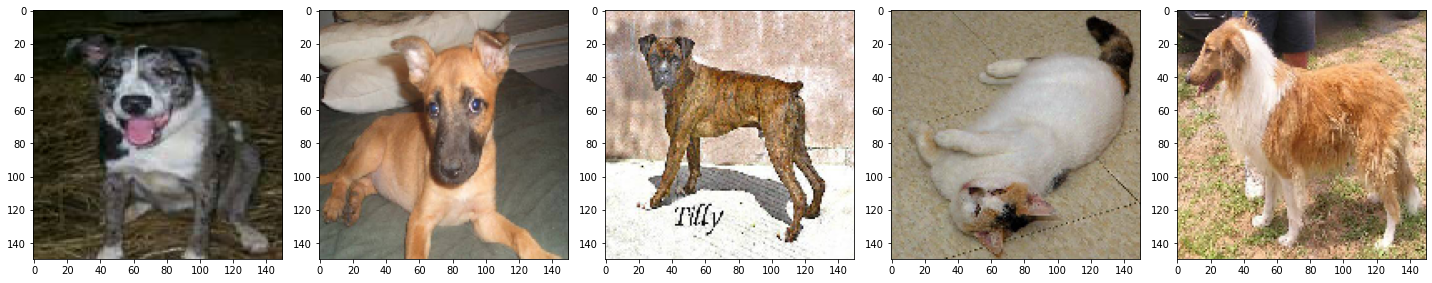

In [21]:
plot_images(sample_training_images[:5])

## Model creation

In [22]:
cnn_model = tf.keras.Sequential([
                                 tf.keras.layers.Conv2D(32, (3, 3), input_shape=(IMG_SHAPE, IMG_SHAPE, 3), activation=tf.keras.activations.relu),
                                 tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

                                 tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.relu),
                                 tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

                                 tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.relu),
                                 tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

                                 tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.relu),
                                 tf.keras.layers.MaxPool2D(pool_size=(2,2)),

                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(512, activation='relu'),
                                 tf.keras.layers.Dense(2, activation='softmax')
])

In [23]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=['accuracy'])

In [24]:
history = cnn_model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    verbose=1,
    validation_data=validation_data_gen
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/35
20/20 [==============================] - 8s 397ms/step - loss: 0.7106 - accuracy: 0.5010 - val_loss: 0.6929 - val_accuracy: 0.5220
Epoch 2/35
20/20 [==============================] - 8s 392ms/step - loss: 0.6929 - accuracy: 0.5135 - val_loss: 0.6910 - val_accuracy: 0.5000
Epoch 3/35
20/20 [==============================] - 8s 390ms/step - loss: 0.6892 - accuracy: 0.5255 - val_loss: 0.6825 - val_accuracy: 0.5200
Epoch 4/35
20/20 [==============================] - 8s 392ms/step - loss: 0.6863 - accuracy: 0.5515 - val_loss: 0.6887 - val_accuracy: 0.5000
Epoch 5/35
20/20 [==============================] - 8s 388ms/step - loss: 0.6836 - accuracy: 0.5345 - val_loss: 0.6665 - val_accuracy: 0.5500
Epoch 6/35
20/20 [==============================] - 8s 392ms/step - loss: 0.6400 - accuracy: 0.6295 - val_loss: 0.6194 - val_accuracy: 0.6690
Epoch 7/35
20/20 [==============================] - 8s 391ms/step - loss

## Visualizing results of the training

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

Text(0.5, 1.0, 'Training and Validation Loss')

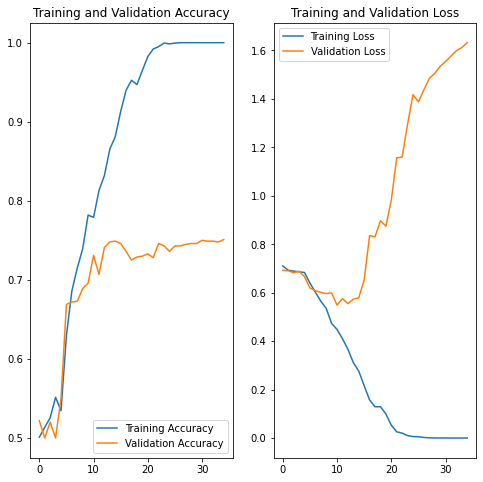

In [31]:
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")

We can clearly see that the validation accuracy has stopped increasing after 20th epoch and the validation loss is increasing after that epoch. This indicates overfitting!